In [1]:
import pydicom
import open3d as o3d
import glob
import numpy as np
import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Axial loading example

In [2]:
paths = glob.glob("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/2448190387/*.dcm")

In [3]:
pydicom.read_file(paths[0])

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 4003253.1.1
(0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 4003253.1.1
(0008, 0023) Content Date                        DA: '20240503'
(0008, 0033) Content Time                        TM: '223716.487580'
(0008, 103e) Series Description                  LO: 'T2'
(0010, 0020) Patient ID                          LO: '4003253'
(0018, 0050) Slice Thickness                     DS: '4.0'
(0018, 0088) Spacing Between Slices              DS: '4.4'
(0018, 5100) Patient Position                   

In [5]:
pcds_xyz = []
pcds_d = []

for path in paths:
    slice = pydicom.read_file(path)
    img = np.expand_dims(slice.pixel_array, -1)
    pcd = o3d.geometry.PointCloud()
    x,y,z=np.where(img)
    
    index_voxel=np.vstack((x,y,z))
    grid_index_array=index_voxel.T
    pcd.points = o3d.utility.Vector3dVector(grid_index_array)
    
    vals = np.array([img[x,y,z] for x,y,z in grid_index_array]) 
    
    dX, dY = slice.PixelSpacing
    X = np.array(list(slice.ImageOrientationPatient[:3]) + [0]) * dX
    Y = np.array(list(slice.ImageOrientationPatient[3:]) + [0]) * dY
    S = np.array(list(slice.ImagePositionPatient) + [1])
    
    transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
    transformed_pcd = pcd.transform(transform_matrix)
    
    pcds_xyz.extend(transformed_pcd.points)
    pcds_d.extend(vals)

In [6]:
pcd_overall = o3d.geometry.PointCloud()
pcd_overall.points = o3d.utility.Vector3dVector(pcds_xyz)
pcd_overall.colors.extend(o3d.utility.Vector3dVector(np.repeat(np.expand_dims(pcds_d, -1) / 256, 3, -1)))

In [7]:
o3d.visualization.draw_geometries([pcd_overall])

In [8]:
voxel_grid = o3d.geometry.VoxelGrid().create_from_point_cloud(pcd_overall, dX)
o3d.visualization.draw_geometries([voxel_grid])

In [9]:
voxels = voxel_grid.get_voxels()

In [10]:
voxels[0]

Voxel with grid_index: (315, 159, 218), color: (0.0117188, 0.0117188, 0.0117188)

In [11]:
coords, vals = (np.array([voxel.grid_index for voxel in voxels]), 
                 np.array([voxel.color[0] for voxel in voxels]))


In [12]:
len(coords), len(vals)

(4079265, 4079265)

In [14]:
coords[0], voxel_grid.get_voxel_center_coordinate(coords[0])

(array([315, 159, 218]), array([  97.51893878,   72.33711849, -444.17052278]))

In [15]:
size = np.max(coords, axis=0) + 1
grid = np.zeros((size[1], size[0], size[2]))

size, grid.shape

(array([321, 351, 329]), (351, 321, 329))

In [16]:
for index, coord in enumerate(coords):
    grid[(coord[1], coord[0], coord[2])] = vals[index] 

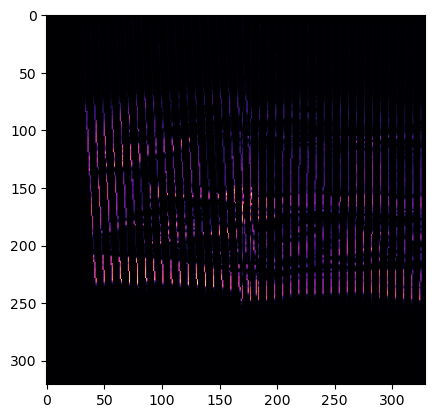

In [17]:
import matplotlib.pyplot as plt
plt.imshow(grid[150,:,:], cmap="magma")
plt.show()

In [1]:
from rsna_dataloader import read_series_as_pcd, read_series_as_voxel_grid

# series = read_series_as_voxel_grid("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/2448190387/")
series = read_series_as_pcd("../data/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/2448190387/")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


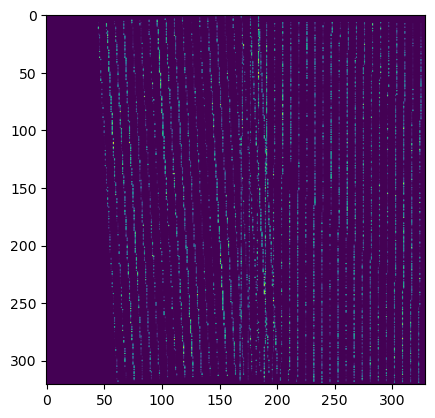

In [24]:
plt.imshow(series[200])

In [2]:
from train_pointnet_model import PointNetEncoder
import numpy as np
import torch

encoder = PointNetEncoder(channel=4).to("cuda")
# with torch.no_grad():
ret = encoder(torch.tensor(np.repeat(np.expand_dims(series[::20], 0), 2, 0))
              .to(torch.float32)
              .permute(0, 2, 1)
              .to("cuda"))
    
print(ret.shape)

torch.Size([2, 1024])


In [3]:
import open3d as o3d

pcd_downsampled = o3d.geometry.PointCloud()
pcd_downsampled.points = o3d.utility.Vector3dVector(series[::20,:3])
pcd_downsampled.colors = o3d.utility.Vector3dVector(np.repeat(np.expand_dims(series[::20,-1], -1), 3, -1) / 256)

In [4]:
o3d.visualization.draw_geometries([pcd_downsampled])

KeyboardInterrupt: 